# Value of disagreement in crowdsourced policymaking

In this notebook we explore the value of disagreement in crowdsourced policymaking by addressing the following research questions.

## Research Questions

1. **RQ1.** What are the predictors of disagreement?
2. **RQ2.** What are the predictors of new ideas?
3. **RQ3.** How does the presence of both disagreement and agreement affect new idea generation? (if disagreement and agreement are present simultaneously, in the same comment/thread?)
4. **RQ4.** Do comments with only disagreement/only agreement lead to more new idea generation?

## Methodology

To address RQ1 and RQ2, numeric variables computed during the qualitative analysis are considered. As the first step, we propose to conduct correlation analyses to understand collinearity between variables. Collinearity between variables might produce incorrect inferences about the association between predictors and the response variable. To address RQ1, logistic regression is employed to model the relationship between predictors and the variable disagreement. Variables that are found to be highly-correlated are not included in the analysis. In answering RQ2, multi-variate linear regression is applied to learn the relationship between predictors and the generation of new ideas. As in the case of RQ1, highly-correlated variables will be excluded from the analysis.

RQ3 is answered by fitting a logistic regression model in which the response variable is whether or not the new ideas are produced while the explanatory variables are agreement and disagreement.

For RQ4, we check the number of comments in which new ideas are produced when there is agreement or disagreement. Also, we count the number of ideas produced in comments than contain agreement and disagreement. Inferential statistics (e.g., student’s t-test) is conducted on the means of ideas produced on comments with agreement and disagreement to understand whether there is a significant difference in the number of ideas produced when agreements are present or vice versa.

## Load libraries

In [552]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats

from collections import defaultdict
from statsmodels.formula.api import glm
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn')

## Load data

### Topic: Member decision making and right

In [89]:
member_df = pd.read_csv('data/member_decision_making_and_right.csv')
nrows, ncols = member_df.shape
print(f'The dataset has {nrows} rows and {ncols} columns')

The dataset has 213 rows and 51 columns


#### Columns

In [90]:
member_df.columns

Index(['Background', 'Proposals', 'Time', 'User ID', 'User email', 'User name',
       'Comment ID', 'Comment', 'Response ID', 'Response', 'Number of likes',
       'Users who liked', 'Attachments', 'Comment.1', 'Response.1', 'Topic 1',
       'Topic 2', 'Topic 3', 'disagreement', 'agreement',
       'simple disagreement', 'elaborated disagreement', 'simple agreement',
       'elaborated agreement', 'idea(s)', 'number of ideas', 'new idea',
       'sourcing', 'value(s)', 'topic shift', 'brainstorming', 'blending',
       'building', 'broadening', 'fact', 'value', 'policy', 'interpretation',
       'target of disagreement', 'target of agreement', 'gives reason(s)',
       'presents evidence', 'asks question(s)', 'provides information',
       'clarifies position/stance', 'responds to previous comment',
       'constructive tone', 'moderator post', 'acknowledges problem', 'notes',
       'annotations for disagreement / new idea cascade(s)'],
      dtype='object')

### Topic: Administration of an association

In [91]:
admin_df = pd.read_csv('data/administration_of_association.csv')
nrows, ncols = admin_df.shape
print(f'The dataset has {nrows} rows and {ncols} columns')

The dataset has 119 rows and 51 columns


#### Columns

In [92]:
admin_df.columns

Index(['Background', 'Proposal', 'Time', 'User ID', 'User email', 'User name',
       'Comment's ID', 'Comment', 'Response ID', 'Response', 'Amount of likes',
       'Users who liked', 'Attachments', 'Comment.1', 'Response.1', 'Topic 1',
       'Topic 2', 'Topic 3', 'disagreement', 'agreement',
       'simple disagreement', 'elaborated disagreement', 'simple agreement',
       'elaborated agreement', 'idea(s)', 'number of ideas', 'new idea',
       'sourcing', 'value(s)', 'topic shift', 'brainstorming', 'blending',
       'building', 'broadening', 'fact', 'value', 'policy', 'interpretation',
       'target of disagreement', 'target of agreement', 'gives reason(s)',
       'presents evidence', 'asks question(s)', 'provides information',
       'clarifies position/stance', 'responds to previous comment',
       'constructive tone', 'moderator post', 'acknowledges problem', 'notes',
       'annotations for disagreement / new idea cascades'],
      dtype='object')

### Topic: Informally organized groups of an association

In [93]:
informal_df = pd.read_csv('data/informally_organized_group_of_a.csv')
nrows, ncols = informal_df.shape
print(f'The dataset has {nrows} rows and {ncols} columns')

The dataset has 159 rows and 53 columns


#### Columns

In [94]:
informal_df.columns

Index(['Background', 'Proposal', 'Time', 'User ID', 'User email', 'User name',
       'Comment ID', 'Comment', 'Response ID', 'Response', 'Number of likes',
       'Users who liked', 'Attachments', 'Comment.1', 'Response.1', 'Topic 1',
       'Topic 2', 'Topic 3', 'disagreement', 'agreement',
       'simple disagreement', 'elaborated disagreement', 'simple agreement',
       'elaborated agreement', 'idea(s)', 'number of ideas', 'new idea',
       'sourcing', 'value(s)', 'topic shift', 'brainstorming', 'blending',
       'building', 'broadening', 'fact', 'value', 'policy', 'IRRpolicy',
       'interpretation', 'IRRinterpretation', 'target of disagreement',
       'target of agreement', 'gives reason(s)', 'presents evidence',
       'asks question(s)', 'provides information', 'clarifies position/stance',
       'responds to previous comment', 'constructive tone',
       'IRRconstructive tone', 'moderator post', 'acknowledges problem',
       'annotations for disagreement / new idea casca

## Preprocess data

### Normalize column names

Put column names to lower case, replace spaces with underscore, delete leading and trailing spaces, and remove non alpha-numerical characters

In [95]:
def normalize_column_names(names):
    names = names.str.lower()
    names = names.str.replace(' ','_')
    names = names.str.replace('.','_')
    names = names.str.replace('(','_')
    names = names.str.replace(')','')
    names = names.str.replace('/','_')
    names = names.str.replace('___','_')
    names = names.str.strip()
    return names

In [96]:
member_df.columns = normalize_column_names(member_df.columns)
admin_df.columns = normalize_column_names(admin_df.columns)
informal_df.columns = normalize_column_names(informal_df.columns)

### Standarize column names

Columns that contained the same information but have slightly different names are renamed for compatibility purposes

In [97]:
member_df = member_df.rename(columns={
    'annotations_for_disagreement_new_idea_cascade_s': 'annotations_for_disagreement_new_idea_cascades'
})

In [98]:
admin_df = admin_df.rename(columns={
    'amount_of_likes': 'number_of_likes',
    'comment\'s_id': 'comment_id',
    'proposal': 'proposals',    
})

In [99]:
informal_df = informal_df.rename(columns={
    'annotations_for_disagreement_new_idea_cascade_s': 'annotations_for_disagreement_new_idea_cascades',
    'proposal': 'proposals'
})

### Merge datasets in one dataframe

Add an extra column to indicate the discussion theme

In [100]:
member_df['topic'] = 'member'
admin_df['topic'] = 'admin'
informal_df['topic'] = 'informal'

Merge datasets

In [101]:
all_df = pd.concat([member_df, admin_df, informal_df], axis=0, ignore_index=True)

In [102]:
nrows, ncols = all_df.shape
print(f'The merged dataset has {nrows} rows and {ncols} columns')

The merged dataset has 491 rows and 55 columns


In [103]:
all_df.columns

Index(['background', 'proposals', 'time', 'user_id', 'user_email', 'user_name',
       'comment_id', 'comment', 'response_id', 'response', 'number_of_likes',
       'users_who_liked', 'attachments', 'comment_1', 'response_1', 'topic_1',
       'topic_2', 'topic_3', 'disagreement', 'agreement',
       'simple_disagreement', 'elaborated_disagreement', 'simple_agreement',
       'elaborated_agreement', 'idea_s', 'number_of_ideas', 'new_idea',
       'sourcing', 'value_s', 'topic_shift', 'brainstorming', 'blending',
       'building', 'broadening', 'fact', 'value', 'policy', 'interpretation',
       'target_of_disagreement', 'target_of_agreement', 'gives_reason_s',
       'presents_evidence', 'asks_question_s', 'provides_information',
       'clarifies_position_stance', 'responds_to_previous_comment',
       'constructive_tone', 'moderator_post', 'acknowledges_problem', 'notes',
       'annotations_for_disagreement_new_idea_cascades', 'topic', 'irrpolicy',
       'irrinterpretation', 'irrc

### Remove columns in Finnish language

Text of comments and responses are both in Finnish and English. Columns `comment` and `response` that contain text in Finnish are removed because they will not be considered in this analysis.

In [104]:
all_df = all_df.drop(['comment', 'response'], axis=1)

Columns `comment_1` and `response_1` are renamed removing `_1` from their names

In [105]:
all_df = all_df.rename(columns={'comment_1': 'comment', 'response_1': 'response'})

Final columns

In [106]:
all_df.columns

Index(['background', 'proposals', 'time', 'user_id', 'user_email', 'user_name',
       'comment_id', 'response_id', 'number_of_likes', 'users_who_liked',
       'attachments', 'comment', 'response', 'topic_1', 'topic_2', 'topic_3',
       'disagreement', 'agreement', 'simple_disagreement',
       'elaborated_disagreement', 'simple_agreement', 'elaborated_agreement',
       'idea_s', 'number_of_ideas', 'new_idea', 'sourcing', 'value_s',
       'topic_shift', 'brainstorming', 'blending', 'building', 'broadening',
       'fact', 'value', 'policy', 'interpretation', 'target_of_disagreement',
       'target_of_agreement', 'gives_reason_s', 'presents_evidence',
       'asks_question_s', 'provides_information', 'clarifies_position_stance',
       'responds_to_previous_comment', 'constructive_tone', 'moderator_post',
       'acknowledges_problem', 'notes',
       'annotations_for_disagreement_new_idea_cascades', 'topic', 'irrpolicy',
       'irrinterpretation', 'irrconstructive_tone'],
      d

### Check null values

Check the number of null values by columns

In [107]:
all_df.isnull().sum()

background                                          3
proposals                                           3
time                                                3
user_id                                             3
user_email                                          3
user_name                                           3
comment_id                                        346
response_id                                       148
number_of_likes                                     0
users_who_liked                                   263
attachments                                       491
comment                                           348
response                                          146
topic_1                                             4
topic_2                                           147
topic_3                                           358
disagreement                                        0
agreement                                           0
simple_disagreement         

## RQ1. Predictors of disagreement

### Define predictor variables for `disagreement`

In [284]:
predictors_disagreement = [
    'number_of_likes', 'number_of_ideas', 'simple_disagreement', 'elaborated_disagreement',
    'topic_shift', 'brainstorming', 'blending', 'building', 'broadening', 'fact',
    'value', 'policy', 'interpretation', 'gives_reason_s', 'presents_evidence', 'asks_question_s',
    'provides_information', 'clarifies_position_stance', 'responds_to_previous_comment', 
    'constructive_tone', 'moderator_post', 'acknowledges_problem'
]
print(f"In total {len(predictors_disagreement)} variables will be considered in the analysis of RQ1")

In total 22 variables will be considered in the analysis of RQ1


### Select predictors and target variable

In [539]:
rq1_df = all_df.loc[:,predictors_disagreement+['disagreement']]
rq1_df.shape

(491, 23)

### Cast variables to numeric

Some variables have the values `unclear` and `nan`, which need to be converted to numerical before casting the variable to this type.

In [522]:
numerical_predictors = ['number_of_likes', 'number_of_ideas']

In [540]:
for col in rq1_df.columns:
    rq1_df.loc[rq1_df[col]=='unclear', col] = 0
    rq1_df.loc[rq1_df[col].isna(), col] = 0
    rq1_df[col] = pd.to_numeric(rq1_df[col], downcast='unsigned')
    if col not in numerical_predictors:
        unique_values = rq1_df[col].unique()
        invalid_values = set(unique_values) - set([0,1])
        if len(invalid_values) > 0:  # the column has invalid values                   
            invalid_indexes = list(rq1_df.loc[~rq1_df[col].isin([0,1])].index)
            if len(invalid_indexes) > 0:
                print(f'Found the following invalid values {invalid_values} in {len(invalid_indexes)} rows of the column {col}. Rows has been discarded.')
                rq1_df = rq1_df.drop(index=invalid_indexes)            

Found the following invalid values {13, 6, 7} in 3 rows of the column simple_disagreement. Rows has been discarded.


In [541]:
rq1_df.shape

(488, 23)

In [542]:
rq1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   number_of_likes               488 non-null    uint8 
 1   number_of_ideas               488 non-null    uint16
 2   simple_disagreement           488 non-null    uint8 
 3   elaborated_disagreement       488 non-null    uint8 
 4   topic_shift                   488 non-null    uint8 
 5   brainstorming                 488 non-null    uint8 
 6   blending                      488 non-null    uint8 
 7   building                      488 non-null    uint8 
 8   broadening                    488 non-null    uint8 
 9   fact                          488 non-null    uint8 
 10  value                         488 non-null    uint8 
 11  policy                        488 non-null    uint8 
 12  interpretation                488 non-null    uint8 
 13  gives_reason_s      

### Check independence between numerical variables

We use Persons correlation to find out whether the numerical variables `number_of_likes` and `number_of_ideas` are correlated.

In [543]:
alpha_level = 0.05

Distribution of `number_of_likes`

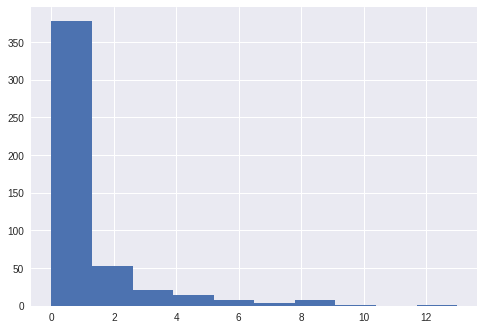

In [544]:
rq1_df['number_of_likes'].hist()

Distribution of `number_of_ideas`

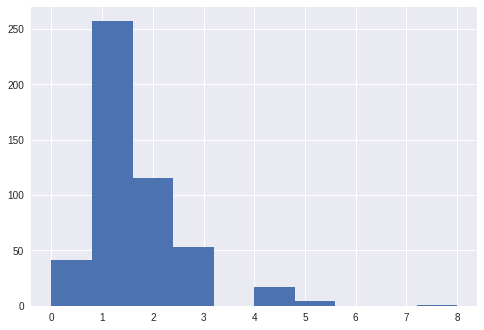

In [545]:
rq1_df['number_of_ideas'].hist()

Because data are not distributed normally, a non-parametric correlation method is used

In [561]:
pearson_stat, p_val = stats.spearmanr(rq1_df['number_of_likes'], rq1_df['number_of_ideas'])

In [563]:
if p_val < alpha_level:
    print(f'Numerical variables are not independent, p-value: {round(p_val,3)}.')
else:
    print(f'Numerical variables are independent, p-value: {round(p_val,3)}.')

Numerical variables are not independent, p-value: 0.011.


Numerical variables are not independent, so they cannot be included together in models.

### Check independence between numerical and categorical variables

Persons correlation is employed to analyze correlation between numerical and categorical variables. Having dichotomous categorical variables, Persons correlation can be used [ref](https://www.researchgate.net/post/Can_I_use_Pearsons_correlation_coefficient_to_know_the_relation_between_perception_and_gender_age_income). 

In [554]:
independence_num_cat = pd.DataFrame(columns=numerical_predictors, index=predictors_disagreement)
independence_num_cat_vars = defaultdict(list)
for predictor_1 in numerical_predictors:    
    for predictor_2 in predictors_disagreement:        
        if predictor_2 == predictor_1:
            continue
        pearson_stat, p_val = stats.spearmanr(rq1_df[predictor_1],rq1_df[predictor_2])        
        if p_val < alpha_level:
            independence_num_cat.loc[predictor_2,predictor_1] = 'F'
        else:
            independence_num_cat.loc[predictor_2,predictor_1] = 'T'
            independence_num_cat_vars[predictor_1].append(predictor_2)

In [556]:
independence_num_cat

,number_of_likes,number_of_ideas
number_of_likes,NaN,F
number_of_ideas,F,NaN
simple_disagreement,T,F
elaborated_disagreement,F,F
topic_shift,F,F
brainstorming,F,F
blending,F,F
building,F,F
broadening,T,F
fact,F,T


`number_of_likes` is independent from

In [558]:
independence_num_cat_vars['number_of_likes']

['simple_disagreement',
 'broadening',
 'value',
 'policy',
 'presents_evidence',
 'provides_information',
 'constructive_tone',
 'acknowledges_problem']

`number_of_ideas` is independent from

In [559]:
independence_num_cat_vars['number_of_ideas']

['fact',
 'presents_evidence',
 'asks_question_s',
 'provides_information',
 'responds_to_previous_comment',
 'constructive_tone']

### Cast categorical variables to category type

In [564]:
for col in rq1_df.columns:
    if col not in numerical_predictors:
        rq1_df[col] = rq1_df[col].astype('category')

In [565]:
rq1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   number_of_likes               488 non-null    uint8   
 1   number_of_ideas               488 non-null    uint16  
 2   simple_disagreement           488 non-null    category
 3   elaborated_disagreement       488 non-null    category
 4   topic_shift                   488 non-null    category
 5   brainstorming                 488 non-null    category
 6   blending                      488 non-null    category
 7   building                      488 non-null    category
 8   broadening                    488 non-null    category
 9   fact                          488 non-null    category
 10  value                         488 non-null    category
 11  policy                        488 non-null    category
 12  interpretation                488 non-null    cate

### Check independence of categorial variables

In [566]:
independece_analysis = pd.DataFrame(columns=predictors_disagreement, index=predictors_disagreement)
for predictor_1 in predictors_disagreement:
    if predictor_1 in numerical_predictors:
        continue
    for predictor_2 in predictors_disagreement:        
        if predictor_2 in numerical_predictors:
            continue
        if predictor_2 == predictor_1:
            continue
        cross_tab = pd.crosstab(rq1_df[predictor_1],rq1_df[predictor_2])
        chi2_stat, p_val, dof, ex = stats.chi2_contingency(cross_tab)
        if p_val < alpha_level:
            independece_analysis.loc[predictor_1,predictor_2] = 'F'
        else:
            independece_analysis.loc[predictor_1,predictor_2] = 'T'

In [567]:
independece_analysis.drop(columns=numerical_predictors, index=numerical_predictors, inplace=True)
independece_analysis

,simple_disagreement,elaborated_disagreement,topic_shift,brainstorming,blending,building,broadening,fact,value,policy,interpretation,gives_reason_s,presents_evidence,asks_question_s,provides_information,clarifies_position_stance,responds_to_previous_comment,constructive_tone,moderator_post,acknowledges_problem
simple_disagreement,NaN,F,T,F,T,T,F,T,F,F,T,F,T,T,T,T,T,F,T,F
elaborated_disagreement,F,NaN,T,F,T,F,T,F,F,F,F,F,F,F,T,F,F,T,F,T
topic_shift,T,T,NaN,F,T,F,F,T,T,F,T,T,T,T,T,F,F,T,T,T
brainstorming,F,F,F,NaN,F,T,F,T,T,T,T,F,T,T,T,T,F,F,T,T
blending,T,T,T,F,NaN,T,T,T,F,F,T,F,T,F,T,T,F,T,T,F
building,T,F,F,T,T,NaN,T,F,T,F,F,F,F,F,F,F,F,T,F,T
broadening,F,T,F,F,T,T,NaN,T,F,T,T,F,F,T,F,T,T,T,F,F
fact,T,F,T,T,T,F,T,NaN,T,T,F,F,F,T,T,F,F,T,T,T
value,F,F,T,T,F,T,F,T,NaN,F,F,F,F,T,T,T,T,T,T,F
policy,F,F,F,T,F,F,T,T,F,NaN,T,F,T,T,F,T,F,T,F,F


### Fit models based on independent predictors

Based on the previous analysis of independencie between categorical variables, predictors will be selected.

In [605]:
possible_models = [None]*len(independece_analysis.columns)
idx = 0
for col in independece_analysis.columns:
    possible_models[idx] = [col]
    for row in independece_analysis.index:
        if independece_analysis.loc[row, col] == 'T':
            possible_models[idx].append(row)
    # Add independent numerical variables
    for num_var, ind_cat_vars in independence_num_cat_vars.items():        
        if col in ind_cat_vars:
            possible_models[idx].append(num_var)
            # After adding a numerical variable to the model
            # we break loop because both numerical variables 
            # cannot be together in a model since they are
            # not independent
            break
    idx += 1

In [606]:
print(f'There are {len(possible_models)} possible models')

There are 20 possible models


Create formulas for the possible models

In [621]:
models = []
for possible_model in possible_models:
    formula = f'disagreement ~ '
    num_predictors = len(possible_model)
    for idx, predictor in enumerate(possible_model):
        if predictor not in numerical_predictors:
            formula += f' C({predictor})'
        else:
            formula += f' {predictor}'
        if idx < (len(possible_model)-1):
            formula += ' + '
    models.append({'formula': formula, 'num_predictors': num_predictors, 'predictors': possible_model})

#### Fit models

In [623]:
idx_not_fitted_models = []
for idx, model_dict in enumerate(models):
    try:
        formula = model_dict['formula']
        model = glm(formula, data = rq1_df, family = sm.families.Binomial()).fit()
        model_dict['model'] = model
        model_dict['deviance'] = model.deviance
        model_dict['log_likelyhood'] = model.llf 
        #models.append(model)
    except Exception as e:
        idx_not_fitted_models.append(idx)
        print(f'Error: {e}.\n\nModel:\n{formula}')
        print()

/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:946: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: invalid value encountered in add
  n * np.log(1 - mu)) * var_weights


Error: Perfect separation detected, results not available.

Model:
disagreement ~  C(provides_information) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(topic_shift) +  C(brainstorming) +  C(blending) +  C(fact) +  C(value) +  C(interpretation) +  C(presents_evidence) +  C(asks_question_s) +  C(clarifies_position_stance) +  C(responds_to_previous_comment) +  C(constructive_tone) +  C(acknowledges_problem) +  number_of_likes



The perfect separation error happens when all values in one of the predictor categories are associated with only one of the binary outcome, see [here](https://stackoverflow.com/questions/53041669/error-perfectseparationerror-perfect-separation-detected-results-not-availab) for more information. A possible solution, which is executed below, is to drop predictors one by one and try if the resulting model can be fitted.

In [626]:
updated_models = []
for idx_not_fitted_model in idx_not_fitted_models:
    predictors = possible_models[idx_not_fitted_model].copy()
    for predictor in predictors:
        ind_vars = possible_models[idx_not_fitted_model].copy()        
        ind_vars.remove(predictor)
        formula = 'disagreement ~ '
        for idx, ind_var in enumerate(ind_vars):
            if ind_var not in numerical_predictors:
                formula += f' C({ind_var})'
            else:
                formula += f' {ind_var}'
            if idx < (len(ind_vars)-1):
                formula += ' + '
        try:
            model = glm(formula, data = rq1_df, family = sm.families.Binomial()).fit()
            print(f'Variable {predictor} has been removed from the predictors list and the model could be fitted.\n')
            updated_models.append(
                {
                    'formula': formula, 
                    'model': model, 
                    'num_predictors': len(ind_vars),
                    'predictors': ind_vars,
                    'deviance': model.deviance,
                    'log_likelyhood': model.llf
                }
            )
        except:
            pass

Variable simple_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable value has been removed from the predictors list and the model could be fitted.

Variable number_of_likes has been removed from the predictors list and the model could be fitted.



In [627]:
print(f'{len(updated_models)} new models could be fitted')

4 new models could be fitted


Update list of fitted models

In [628]:
models.extend(updated_models)

In [629]:
len(models)

24

In [638]:
models[0]

{'formula': 'disagreement ~  C(simple_disagreement) +  C(topic_shift) +  C(blending) +  C(building) +  C(fact) +  C(interpretation) +  C(presents_evidence) +  C(asks_question_s) +  C(provides_information) +  C(clarifies_position_stance) +  C(responds_to_previous_comment) +  C(moderator_post) +  number_of_likes',
 'num_predictors': 13,
 'predictors': ['simple_disagreement',
  'topic_shift',
  'blending',
  'building',
  'fact',
  'interpretation',
  'presents_evidence',
  'asks_question_s',
  'provides_information',
  'clarifies_position_stance',
  'responds_to_previous_comment',
  'moderator_post',
  'number_of_likes'],
 'model': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f7656e24160>,
 'deviance': 278.5913033410134,
 'log_likelyhood': -139.2956516705067}

In [645]:
min_llf = 1000
best_model = None
for model in models:
    if 'log_likelyhood' in model and model['log_likelyhood'] < min_llf:
        min_llf = model['log_likelyhood']
        best_model = model

In [646]:
best_model

{'formula': 'disagreement ~  C(gives_reason_s) +  C(topic_shift) +  C(responds_to_previous_comment) +  C(constructive_tone)',
 'num_predictors': 4,
 'predictors': ['gives_reason_s',
  'topic_shift',
  'responds_to_previous_comment',
  'constructive_tone'],
 'model': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f7656e31e10>,
 'deviance': 595.9994620353666,
 'log_likelyhood': -297.9997310176833}

## Detect multicollinearity

The first step in addressing RQ1 is to detect multicollinearity between predictors. Multicollinearity occurs when two predictors or independent variables are highly correlated and it makes difficult to distinguish the effect of the collineared variables on the response variable. The method **`variance inflation factor (VIF)`** will be used to detect multicollinearity. VIF determines the strenght correlation between independent variables by taking a variable and regressing it against the others. Thus, VIF score on an independent variable represents how well the variability on variables is explained by the others variables.

In [338]:
banned_predictors = ['constructive_tone', 'gives_reason_s', 'building', 'policy', 'number_of_ideas',
                     'responds_to_previous_comment', 'brainstorming', 'elaborated_disagreement', 
                     'acknowledges_problem', 'moderator_post', 'topic_shift', 'blending', 'value',
                     'fact', 'asks_question_s', 'clarifies_position_stance', 'presents_evidence',
                     'number_of_likes', 'simple_disagreement', 'broadening']
selected_predictors = predictors_disagreement.copy()
for banned_predictor in banned_predictors:    
    selected_predictors.remove(banned_predictor)
predictors = rq1_df.loc[:,selected_predictors]
predictors['Intercept'] = 1
vif = pd.DataFrame()
vif['variables'] = predictors.columns
vif['VIF'] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

In [339]:
vif.sort_values('VIF', ascending=False)

,variables,VIF
0,number_of_ideas,42.741548
1,interpretation,23.395039
2,provides_information,7.901185
3,Intercept,1.024453
